In [1]:
###Importing the packages 

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.utils import np_utils


# Multiple Inputs
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D,SeparableConv2D,DepthwiseConv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


**Dataset** : Loading the data and splitting into test and train

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

**Helper Function** : To display the data read 

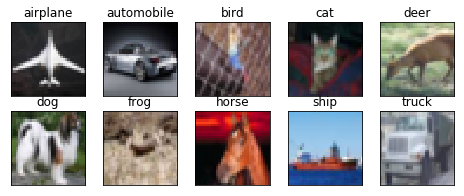

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

**Training Set** : Splitting of train and test data 

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [7]:
weight_decay = 0.005

# Input layer
img = Input(shape=(32,32,3))

# first convolution block
x = Conv2D(64, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(img) #32
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  
x = Conv2D(64, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #32
x = BatchNormalization()(x)
x = Dropout(0.4)(x) 

# first transition block with bottlneck
x = MaxPooling2D(pool_size=(2, 2))(x) #16
x = Conv2D(64, kernel_size=1, activation='relu')(x)



# second convolution block
#******************************************GROUPED CONVOLUTION*************
x = Conv2D(128, kernel_size=3, padding='same',dilation_rate=(1, 1), activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #16
x = BatchNormalization()(x)
x = Dropout(0.4)(x) 

# Dilated Convolutino with dilation rate of 2
x1 = Conv2D(512, kernel_size=3, padding='same', dilation_rate=(2, 2), activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #4
x1 = BatchNormalization()(x1)
x1 = Dropout(0.4)(x1)

x = concatenate([x1, x])
x = Conv2D(512, kernel_size=1, activation='relu')(x)
#*******************************************************************************
x = Conv2D(128, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #16
x = BatchNormalization()(x)
x = Dropout(0.4)(x) 

# second transition block with bottlneck
x = MaxPooling2D(pool_size=(2, 2))(x) #8
x = Conv2D(64, kernel_size=1, activation='relu')(x)


# third convolution block
x = Conv2D(256, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #8
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  
# ******************spacial separable convolution****************************
# x = Conv2D(256, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #8
x = Conv2D(256, kernel_size=(3,1), padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #8
x = Conv2D(256, kernel_size=(1,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #8
# **************************************************************************************
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2D(256, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #8
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# third transition block with bottlneck
x = MaxPooling2D(pool_size=(2, 2))(x) #4
x = Conv2D(64, kernel_size=1, activation='relu')(x)

# fourth convolution block
#******************************************GROUPED CONVOLUTION*************
x = Conv2D(512, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #4
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x1 = Conv2D(512, kernel_size=5, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #4
x1 = BatchNormalization()(x1)
x1 = Dropout(0.4)(x1)


x = Conv2D(512, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #4
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# print("test",np.shape(concatenate([x1, x])))

x = concatenate([x1, x])
x = Conv2D(512, kernel_size=1, activation='relu')(x)
#****************************************************************************************


# fourth transition block with bottlneck
x = MaxPooling2D(pool_size=(2, 2))(x) #2
x = Conv2D(64, kernel_size=1, activation='relu')(x)

# fifth convolution block
x = Conv2D(512, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #2
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  
# ***************************Depthwise seperable convolution **************************
x = SeparableConv2D(512, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #2
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# fifth transition block with bottlneck
x = MaxPooling2D(pool_size=(2, 2))(x) #1
x = Conv2D(64, kernel_size=1, activation='relu')(x)


# final convolution block
x = Conv2D(512, kernel_size=3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(x) #1
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  
x = Conv2D(10, kernel_size=3, padding='same')(x) #1

x = Flatten()(x)
output = Activation('softmax')(x)


model = Model(inputs=[img], outputs=output)
# summarize layers
print(model.summary())

W0619 07:12:50.402093 140488880756608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 07:12:50.434832 140488880756608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0619 07:12:50.446301 140488880756608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0619 07:12:50.511100 140488880756608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0619 07:12:50.512471 1404888807

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

**Training params**  : Below are the fine tuned hyper params 

Optimizer : Adam 

Learning rate : 0.01 

decay = 0.005

epochs= 50

In [8]:
from keras.optimizers import adam
adam = adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8,decay=0.005)
model.compile(loss='categorical_crossentropy',
             optimizer=adam,
             metrics=['accuracy'])

W0619 07:13:05.125357 140488880756608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':
W0619 07:13:09.192246 140488880756608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will

Epoch 1/50
390/390 [==============================] - 278s 712ms/step - loss: 8.8741 - acc: 0.1788 - val_loss: 3.1973 - val_acc: 0.1672
Epoch 2/50
390/390 [==============================] - 264s 678ms/step - loss: 2.6287 - acc: 0.2286 - val_loss: 2.6352 - val_acc: 0.1115
Epoch 3/50
390/390 [==============================] - 261s 670ms/step - loss: 2.1486 - acc: 0.2648 - val_loss: 2.4615 - val_acc: 0.1658
Epoch 4/50
390/390 [==============================] - 261s 670ms/step - loss: 2.0436 - acc: 0.3181 - val_loss: 2.2903 - val_acc: 0.2398
Epoch 5/50
390/390 [==============================] - 261s 669ms/step - loss: 1.8735 - acc: 0.3934 - val_loss: 2.5498 - val_acc: 0.1508
Epoch 6/50
390/390 [==============================] - 261s 668ms/step - loss: 1.7663 - acc: 0.4521 - val_loss: 2.3017 - val_acc: 0.2230
Epoch 7/50
390/390 [==============================] - 261s 668ms/step - loss: 1.6767 - acc: 0.5020 - val_loss: 2.0505 - val_acc: 0.3446
Epoch 8/50
390/390 [============================

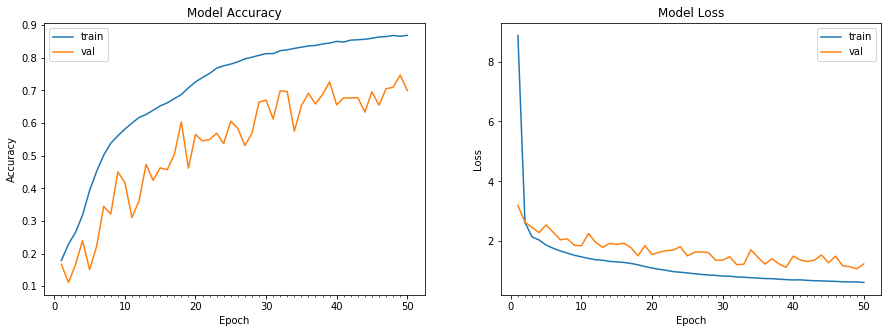

Accuracy on test data is: 70.03


In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))


**Theory ** : 

**Spacial separable convolution**:  In the above architecture added spacial separable convolution, at third convolution block's second convolution layer. Number of parameters for this layer 3x1x256x256+1x3x256x256 adding bias parameters we get the number 196864+196864 parameters shown in the summary of keras model. Compared to original 3x3 conv2D layer which has 3x3x256x256 has 1.5 times more parameters compared to our spacially separable convolution.


**Depthwise seperable convolution:** In the above architecture added spacial separable convolution, at fifth convolution block's second convolution layer. Number of parameters for this layer 3x3x512+1x1x512x512 adding bias parameters(512) we get the number 267264 parameters shown in the summary of keras model. Here SeparableConv2D performs depthwise convolution followed by pointwise convolution. This leads to saving of parameters compared to normal 3x3 convolution, which has 3x3x512x512 which has 8.82 times more numer of parameters compared to Depthwise seperable convolution.


**Grouped convolution:**

1. Used two grouped convolutions the network. Each group convolution layer has two parallel convoution layers.

2. Second and fourth convolution blocks have grouped convolutions.

3. Used Grouped convolution to make sure that early feature and later features are used together for the training process.

4. Grouped convolution in the second convolution block is using 2 parallel convolution blocks, with one the blocks using a dilated convolution with a dialation rate of 2. This means, the kernel of 3x3 will have a receptive field effect of 5x5 with the kernel coverate area spread out with a gap of one pixel surrounding each kernel element. 


5. This is good for global feature extraction. For another parallel layer we use a dilation rate of 1 which is nothing but a normal convolution layer.

6. Parallel layers of grouped convolution are concatinated. This will increase the number of channels. I used 1x1 or pointwise convolution to reduce the number of channels.

7. Grouped convolution in the fouth convolution block is using two parallel convolution blocks, it has only three simple 3x3 and 5x5 convolution layers.


8. With all the parallel layers of grouped convolutions the parameter count as gone up substancially to 13 Million. We need to fine tune the network, to reduce the number of parameters in future. Aim of this notebook is to only add different types of convolutions specified above, but not for parameter efficiency or better accuracy.

9. After training the network for 100 epoch, I arrived at validation acc of 72.57% and a training acc of 86.38%. Which is an improvement on the baseline of val_acc: 0.8340.



